# Keras 101 - Linear Model on MNIST

In this Notebook, we will program simple Keras examples using the Sequential API.

## Import the relevant libraries

In [1]:
# Utility libraries
import os
import random
from datetime import datetime

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt # For plotting purposes


# Bug still not solved, resort to old keras module (see below)
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Use the above import when the bug is solved
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
# ------------------------------------------#

Using TensorFlow backend.


In [2]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

## MNIST Data Loading and Preprocessing

In [3]:
# Each MNIST image has shape (28,28)
mnist_img_rows, mnist_img_cols = 28, 28
dim_target = 10

# Load the MNIST dataset, which has already been splitted into training and test set
(mnist_train, mnist_y_train), (x_test, y_test) = mnist.load_data()

### What is the shape of our data?

In [4]:
print(f'Training set has {mnist_train.shape[0]} examples of {mnist_train.shape[1:]} features each value')
print(f'Training targets have shape {mnist_y_train.shape} i.e. we will predict a constant target value for each example')
print('')
print(f'Test set has {x_test.shape[0]} examples of {x_test.shape[1:]} features each value')
print(f'Test targets have shape {y_test.shape} i.e. we will predict a constant target value for each example')
print('')
print(f'Examples have type {mnist_train.dtype}, targets have type {mnist_y_train.dtype}')

Training set has 60000 examples of (28, 28) features each value
Training targets have shape (60000,) i.e. we will predict a constant target value for each example

Test set has 10000 examples of (28, 28) features each value
Test targets have shape (10000,) i.e. we will predict a constant target value for each example

Examples have type uint8, targets have type uint8


## Extract a validation set from the training set (the Pythonic way)

Alternatively, you can use scikit-learn when working with NumPy matrices. Use the ``sklearn.model_selection.train_test_split`` function (that you can use to extract a train/test split from the whole dataset and a validation set from the train set) or the ``sklearn.model_selection.KFold`` function for k-fold (external or internal) cross validation. **Remember: external cross validation is used for model assessment (average of k performances on unseen TEST data), whereas internal cross validation is used for model selection (average of k performances on VALIDATION data to select the best configuration)**

In [5]:
def extract_subset(x_dataset, y_dataset, subset_percentage=10):
    # Choose a seed to obtain the same split
    random.seed(42)
    
    no_samples = x_dataset.shape[0]

    # Generate a list of indices
    indices = [i for i in range(no_samples)]

    # We want the x% of the training set to be used as a validation set
    no_subset_samples = int((no_samples/100)*subset_percentage)

    # In place shuffling of the data structure
    random.shuffle(indices)

    # Display the indices
    # print(f'Validation indices are: {indices[:no_subset_samples]}')

    # The subset will correspond to the first "no_subset_samples" shuffled indices
    x_subset = x_dataset[indices[:no_subset_samples], :]
    y_subset = y_dataset[indices[:no_subset_samples]]

    # The rest of the data will correspond to other shuffled indices
    new_x_dataset = x_dataset[indices[no_subset_samples:], :]
    new_y_dataset = y_dataset[indices[no_subset_samples:]]
    
    return (new_x_dataset, new_y_dataset), (x_subset, y_subset)

In [6]:
# Extract a validation set from the TRAINING set.
# You can also use this function to split you entire dataset into training, validation and test sets when these are not given.
(x_train, y_train), (x_valid, y_valid) = extract_subset(mnist_train, mnist_y_train, subset_percentage=10)

In [7]:
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255
x_valid = x_valid.reshape(x_valid.shape[0], -1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

The associated target label is 3


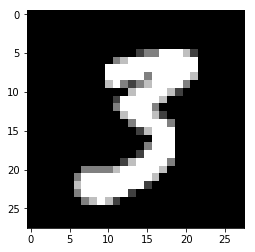

In [8]:
plt.imshow(x_train[0].reshape(mnist_img_rows, mnist_img_cols), cmap='gray')
print(f'The associated target label is {y_train[0]}')

## First define the hyper-parameters of the model
### Later, we can try to do model selection via random search on hyper-parameters ranges

In [9]:
# Hyper-parameters of the model
l1_regularization = 0.  # L1 regularization to be applied to the weight matrix W
l2_regularization = 1e-5  # L2 regularization to be applied to the weight matrix W
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Mini-batch training for stochastic gradient descent
no_epochs = 20  # Maximum number of epochs to train the model

## Construct a Linear model

In [10]:
# We will define a linear model with the Sequential API
linear = Sequential()

# Let's add the connection between input and output
linear.add(Dense(units=dim_target,  # depends on the task at hand
                 activation='linear',  # the identiy mapping (no need to use non-linearities here, it's a linear model!)
                 use_bias=True,  # we want to implement Wx + b where b is the bias
                 kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization)  # Regularizes the weight matrix W                 
                 ))

## Prepare the model for training

In [11]:
linear.compile(optimizer=optimizers.SGD(lr=learning_rate),  # Optimizer
              # Loss function to minimize
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse will convert categorical labels for us in one-hot form!
              # List of metrics to monitor
              metrics=[metrics.sparse_categorical_accuracy])

In [12]:
# Clear any logs from previous runs
!rm -rf ./logs_linear

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = "logs_linear/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Chekpoint path for storing our model
checkpoint_path = "checkpoints/linear/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# There are many possible ways to store a model, for example every n epochs. Check the documentation, very useful!
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,  # Save only the best epoch according to valid set
                                                 monitor="val_sparse_categorical_accuracy",  # Save according to valid acc
                                                 verbose=1,
                                                 save_weights_only=False,  # we want to save the graph as well  
                                                 )  

# Train the Model!
# Note: fit has also the chance to specify a validation split percentage
print('# Fit model on training data')
history = linear.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_valid, y_valid),
                    callbacks=[save_callback, tensorboard_callback]
                    )

# Fit model on training data
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
52608/54000 [============================>.] - ETA: 0s - loss: 2.0157 - sparse_categorical_accuracy: 0.3591
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.59650, saving model to checkpoints/linear/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/linear/cp.ckpt/assets
54000/54000 [==============================] - 3s 53us/sample - loss: 2.0073 - sparse_categorical_accuracy: 0.3654 - val_loss: 1.6956 - val_sparse_categorical_accuracy: 0.5965
Epoch 2/20
53632/54000 [============================>.] - ETA: 0s - loss: 1.4880 - sparse_categorical_accuracy: 0.6914
Epoch 00002: val_sparse_categorical_accuracy improved from 0.59650 to 0.74183, saving model to checkpoints/linear/cp.ckpt
INFO:tensorflow:Assets written to: checkpoints/linear/cp.ckpt/assets
54000/54000 [==============================] - 2

Epoch 17/20
53184/54000 [============================>.] - ETA: 0s - loss: 0.5496 - sparse_categorical_accuracy: 0.8662
Epoch 00017: val_sparse_categorical_accuracy improved from 0.86633 to 0.86783, saving model to checkpoints/linear/cp.ckpt
INFO:tensorflow:Assets written to: checkpoints/linear/cp.ckpt/assets
54000/54000 [==============================] - 2s 38us/sample - loss: 0.5496 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.5508 - val_sparse_categorical_accuracy: 0.8678
Epoch 18/20
52800/54000 [============================>.] - ETA: 0s - loss: 0.5392 - sparse_categorical_accuracy: 0.8678
Epoch 00018: val_sparse_categorical_accuracy improved from 0.86783 to 0.86933, saving model to checkpoints/linear/cp.ckpt
INFO:tensorflow:Assets written to: checkpoints/linear/cp.ckpt/assets
54000/54000 [==============================] - 2s 38us/sample - loss: 0.5394 - sparse_categorical_accuracy: 0.8676 - val_loss: 0.5412 - val_sparse_categorical_accuracy: 0.8693
Epoch 19/20
52544/54000 [=

In [13]:
# Visualize your model
%tensorboard --logdir {logdir}

## Load the model from disk (for demo purposes)

In [14]:
model = tf.keras.models.load_model(checkpoint_path)

## Test time! 
### We cannot change the hyper-parameters once we evaluate on test!



In [16]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)  # Verbose 0 does not show any log
print(f'Test loss: {score[0]}, Test Accuracy: {score[1]*100}')

Test loss: 0.49705806546211245, Test Accuracy: 87.91000247001648


# IMPORTANT
## We found the TEST accuracy of our linear model. There's no turning back now, you should go to your boss to report this result.
## If you start again changing hyper-parameters and see if it improves on TEST, that is dead wrong! You are using the TEST as a VALIDATION !!

### Instead, take some more time to validate a broader range of configurations on the VALIDATION test.

## Let's classify one example from the test set

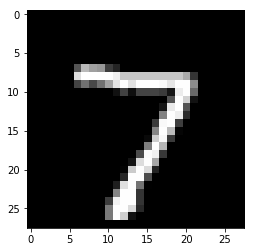

In [17]:
plt.imshow(x_test[0].reshape(mnist_img_rows, mnist_img_cols), cmap='gray')

In [18]:
# Add a softmax activation to get probabilities
model.add(Softmax())

# Predict output
y = model.predict(np.expand_dims(x_test[0,:], 0))

print(f'The class that has maximum probability associated to the input is: {np.argmax(y)}')

The class that has maximum probability associated to the input is: 7




# Exercise time! Change the code below to train an MLP!
## I have included a complete example with the code to perform model selection via random search.

<img src="https://drive.google.com/uc?id=1lRjIAnAV9kPNMWPOcF3ub4odChbTkFwR" max-heigth=50%>

In [29]:
# Clear any logs
!rm -rf ./logs_linear/model_selection


# Hyper-parameters ranges of the model
l1_regularization = 0.
l2_regularization = (1e-3, 1e-5)
learning_rate = (1e-3, 5e-3)
batch_size = 64
no_epochs = (20, 50)


# Data structure to store the best configuration tried on the VALIDATION set
best_config = {"val_score": 0.,
               "l1_regularization": None,
               "l2_regularization": None,
               "learning_rate": None,
               "batch_size": None,
               "no_epochs": None,
               "config_id": None,
               }

no_random_searches = 5

for i in range(no_random_searches):
    
    # Select a random configuration
    l2 = random.uniform(l2_regularization[0], l2_regularization[1])
    lr = random.uniform(learning_rate[0], learning_rate[1])
    epochs = random.randint(no_epochs[0], no_epochs[1])
    
    # We will define a linear model with the Sequential API
    model = Sequential()

    # Let's add the connection between input and output
    model.add(Dense(units=dim_target,  # depends on the task at hand
                     activation='linear',  # the identiy mapping (no need to use non-linearities here, it's a linear model!)
                     use_bias=True,  # we want to implement Wx + b where b is the bias
                     kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2)  # Regularizes the weight matrix W                 
                     ))
    
    model.compile(optimizer=optimizers.SGD(lr=lr),  # Optimizer
                   # Loss function to minimize
                   loss=losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse will convert categorical labels for us in one-hot form!
                   # List of metrics to monitor
                   metrics=[metrics.sparse_categorical_accuracy])


    # Set up a log folder in which we will store the output to be displayed on TensorBoard
    logdir = f"logs_linear/model_selection/config_{i}/fit/"
    tensorboard_callback = TensorBoard(log_dir=logdir)

    # Train the Model!
    # Note: fit has also the chance to specify a validation split percentage
    print('# Fit model on training data')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        # We pass some validation for
                        # monitoring validation loss and metrics
                        # at the end of each epoch
                        validation_data=(x_valid, y_valid),
                        callbacks=[tensorboard_callback]
                        )
    
    score = model.evaluate(x_valid, y_valid, batch_size=128, verbose=0)  # Verbose 0 does not show any log
    print(f'Validation loss: {score[0]}, Validation Accuracy: {score[1]*100}')
    
    if score[1]*100 >= best_config['val_score']:
        best_config['val_score'] = score[1]*100
        best_config['l1_regularization'] = l1_regularization
        best_config['l2_regularization'] = l2
        best_config['learning_rate'] = lr
        best_config['no_epochs'] = no_epochs
        best_config['batch_size'] = batch_size
        best_config['config_id'] = i


# Fit model on training data
Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 1s 24us/sample - loss: 1.5150 - sparse_categorical_accuracy: 0.6256 - val_loss: 1.0551 - val_sparse_categorical_accuracy: 0.7928
Epoch 2/25
54000/54000 [==============================] - 1s 22us/sample - loss: 0.8937 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.8368
Epoch 3/25
54000/54000 [==============================] - 1s 23us/sample - loss: 0.7147 - sparse_categorical_accuracy: 0.8418 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.8505
Epoch 4/25
54000/54000 [==============================] - 1s 23us/sample - loss: 0.6281 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.6022 - val_sparse_categorical_accuracy: 0.8577
Epoch 5/25
54000/54000 [==============================] - 1s 23us/sample - loss: 0.5757 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.5607 - val_sparse_categorical_accu

Epoch 17/43
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4489 - sparse_categorical_accuracy: 0.8876 - val_loss: 0.4552 - val_sparse_categorical_accuracy: 0.8843
Epoch 18/43
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4438 - sparse_categorical_accuracy: 0.8887 - val_loss: 0.4506 - val_sparse_categorical_accuracy: 0.8855
Epoch 19/43
54000/54000 [==============================] - 1s 21us/sample - loss: 0.4391 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.4462 - val_sparse_categorical_accuracy: 0.8865
Epoch 20/43
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4349 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8882
Epoch 21/43
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4309 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.4387 - val_sparse_categorical_accuracy: 0.8890
Epoch 22/43
54000/54000 [==============================] - 1

Epoch 17/48
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5536 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.5552 - val_sparse_categorical_accuracy: 0.8687
Epoch 18/48
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5444 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.5465 - val_sparse_categorical_accuracy: 0.8697
Epoch 19/48
54000/54000 [==============================] - 1s 20us/sample - loss: 0.5359 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.5387 - val_sparse_categorical_accuracy: 0.8710
Epoch 20/48
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5283 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.5316 - val_sparse_categorical_accuracy: 0.8708
Epoch 21/48
54000/54000 [==============================] - 1s 22us/sample - loss: 0.5212 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.5249 - val_sparse_categorical_accuracy: 0.8718
Epoch 22/48
54000/54000 [==============================] - 1

Epoch 12/20
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5391 - sparse_categorical_accuracy: 0.8695 - val_loss: 0.5414 - val_sparse_categorical_accuracy: 0.8708
Epoch 13/20
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5271 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.5301 - val_sparse_categorical_accuracy: 0.8717
Epoch 14/20
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5165 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.5204 - val_sparse_categorical_accuracy: 0.8740
Epoch 15/20
54000/54000 [==============================] - 1s 21us/sample - loss: 0.5072 - sparse_categorical_accuracy: 0.8756 - val_loss: 0.5118 - val_sparse_categorical_accuracy: 0.8753
Epoch 16/20
54000/54000 [==============================] - 1s 20us/sample - loss: 0.4989 - sparse_categorical_accuracy: 0.8771 - val_loss: 0.5041 - val_sparse_categorical_accuracy: 0.8767
Epoch 17/20
54000/54000 [==============================] - 1

In [30]:
print(best_config)

{'val_score': 90.01666903495789, 'l1_regularization': 0.0, 'l2_regularization': 0.0005833206654935294, 'learning_rate': 0.0032105085823332024, 'batch_size': 64, 'no_epochs': (20, 50), 'config_id': 1}


### Cool! We automatically found our best candidate :) now test it on test! Then there's no turning back ;)

In [39]:
# Visualize your winning model
%tensorboard --logdir ./logs_linear/model_selection/config_{best_config["config_id"]}/fit/

In [41]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)  # Verbose 0 does not show any log
print(f'Test loss: {score[0]}, Test Accuracy: {score[1]*100}')

Test loss: 0.4486263397216797, Test Accuracy: 89.06000256538391
